# CS 101:  Introduction to Computing for Science and Engineering

## `lab09`—Waves and Harmonies

❖ Objectives

-   Utilize NumPy to construct and solve a numerical system.
-   Apply the finite difference method to solve the wave equation in one dimensions.
-   Utilize SciPy for special functions useful in solving the wave equation in two dimensions.

<div class="alert alert-warning">
**Pair Programming**
<br />
Since this lab is fairly involved, we encourage you to work in pairs *at a single machine*.  You and your partner will consult, and should occasionally trade off so that the time at the keyboard is roughly equal.  At the end, when you report collaborators, please report the names and NetIDs of all partners in this lab exercise.  (In exceptional cases, such as the room layout, trios are permitted.)
</div>

The ancient Greek Pythagoras believed that numbers—particularly *ratios*—were divine correspondences which underlay and revealed the nature of the cosmos.  According to legend, he discovered the ratios of musical notes by listening to ringing hammers of various weights as well as strings of different lengths, and launched the theoretical exploration of both music and pure mathematics.

In today's lab, we will explore harmonics and numerically solve certain cases of string and plate harmonics using NumPy and SciPy.  As we will use these throughout, first we'll go ahead and import the libraries:

In [1]:
# Make sure that you run this cell to import the necessary libraries.
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = 7,7

/class/cs101/etc/venv/cs101-fa16/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Simple String Harmonics

A plucked string vibrates.  This is a simple observation, but how much of music depends on it!  We're going to model how vibrations travel as waves through a string, just like these vibrations:

![](https://upload.wikimedia.org/wikipedia/commons/0/00/Vibration_corde_trois_modes.gif)

Vibrations are waves, and as such they are governed by the *wave equation*.  We'll numerically solve this equation for a string and then for a plate, which will give you an idea how basic numerical algorithms work in Python.

#### Governing Equations

Although you don't need to know differential equations to complete this lab, a little background will help you comprehend why the solutions work as they do.  For a string in one dimension, we can write the *wave equation* to describe how it moves in space given certain *boundary conditions*  The boundary conditions specify that the string ends are secured, or *fixed*.  For a $1 \,\text{m} \times 1 \,\text{m}$ plate,

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray}
$$

$u$ describes the position of the string at location $x$ at time $t$.  The wave equation means that the propagation of a disturbance (a wave) in *time* can be related to its propagation in space via the speed of travel $c$.  That's just what the second derivatives do in this equation.

We'll use the *finite difference method* to numerically solve this problem.  In FDM, one converts a differential equation over a continuous space to a matrix equation over a grid.

![](./img/fdm.png)

(As you can see, one consequence of this is that we will only have solutions at grid points rather than everywhere.  Some error is necessarily introduced in this process.)

We will approximate a spatial derivative thus:

$$
\frac{\partial u}{\partial x} \approx \frac{u_{i}-w_{i-1}}{\Delta x}
$$

($i$ means the grid point number).  We will do the same in time:

$$
\frac{\partial u}{\partial t} \approx \frac{u^{n}-u^{n-1}}{\Delta t}
$$

($n$ means the time step number, *not* an exponent).

So instead of trying to analytically solve the equation

$$
\frac{\partial^2 u}{\partial t^2} + c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray} \,\text{,}
$$

we'll numerically solve the equation

$$
\frac{u^{n+1}_{i} - 2u^{n}_{i} + u^{n-1}_{i}}{\Delta t^2} - c^2 \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{\Delta x^2} = 0
\hspace{2cm}
\begin{eqnarray}
u^n_0 = 0 \\
u^n_{i_{\max}} = 0
\end{eqnarray} \,\text{.}
$$

or, for a single grid point,

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

$\Delta t$ and $\Delta x$ represent the time step size and spatial grid size, respectively.

That looks intimidating, doesn't it?  Let's see what's going on.

Basically, we've created a grid describing a string.  We then have a way of relating the *current* ($n$) and *past* ($n-1$) grids together to predict the *next step* grid ($n+1$).  This equation just tells us what the proportions of the other grid values should be in order to obtain an estimate of $u^{n+1}_{i}$.

![](./img/fdm-stencil.png)

#### Implementation

First let's define the broad parameters of our simulation.  Any time we want to run this simulation for slightly different circumstances, these are the values we need to revisit.

-   Create the following variables.  Include appropriate comments.

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `c`      | `0.01`  | wave velocity |
| `t`      | `10.0` | maximum time |
| `nt`     | `100`  | number of time steps (total) |
| `xmin`   | `0.0`  | minimum $x$-coordinate |
| `xmax`   | `1.0`  | maximum $x$-coordinate |
| `nx`     | `25`   | number of grid coordinates |
| `dt`     | $\frac{t}{n_t}$ | size of time step |
| `dx`     | $\frac{x_{\max} - x_{\min}}{n_x}$ | size of grid coordinates |

In [10]:
#  Create your variables here.
c = 0.01 #wave velocity
t = 10.0 #maximum time
nt = 100 #munber of time steps (total)
xmin = 0.0 #minimum x-coordinate
xmax = 1.0 #maximum x-coordinate
nx = 25 #number of grid coordinates
dt = t / nt # size of time step
dx = (xmax - xmin) / nx #size of grid coordinates

In [11]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type(c)    == float and c    == 0.01
assert type(t)    == float and t    == 10.0
assert type(nt)   == int   and nt   == 100
assert type(xmin) == float and xmin == 0.0
assert type(xmax) == float and xmax == 1.0
assert type(nx)   == int   and nx   == 25
assert isclose(dt, 0.1)
assert isclose(dx, 0.04)
print('Success!')

Success!


We need a few places to track data in order to grease our numerical machinery in a moment.  We'll use NumPy arrays to store our grid values.  Making a grid is straightforward with NumPy.  We will use the function [`zeros`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html), which accepts a *length* and returns an array of that size.  You may also find the function [`linspace`](docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to be useful in defining `x` from `xmin` to `xmax`, with `nx+1` points to generate `nx` intervals.

For example, try the following:

In [12]:
np.linspace( 0, 5, 11 )

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

-   Define the following array variables.  These should be sufficient to store all grid values as well as the left and right boundary conditions.  For that purpose, they should be `nx+1` points in length.

| Variable | Purpose |
| -------- | ------- |
| `u`      | store current grid values (representing time step $n$) |
| `uold`   | store past grid values (representing time step $n-1$) |
| `unew`   | store future grid values (representing time step $n+1$) |
| `x`      | $x$ positions along grid, $x_i$ |

In [48]:
#  Create your array variables here.
u = np.zeros(nx+1)
uold = np.zeros(nx+1)
unew = np.zeros(nx+1)
x = np.linspace(xmin,xmax,nx+1)
print(u)
print(u[10])
u.shape
print(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
0.0
[ 0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4   0.44
  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88  0.92
  0.96  1.  ]


In [29]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type(u)    == np.ndarray and u.shape    == (nx+1,) and u[10]    == 0.0
assert type(uold) == np.ndarray and uold.shape == (nx+1,) and uold[10] == 0.0
assert type(unew) == np.ndarray and unew.shape == (nx+1,) and unew[10] == 0.0
assert type(x)    == np.ndarray and x.shape    == (nx+1,) and isclose(x[10], 0.4)
print('Success!')

Success!


We now require an initial condition.  We didn't specify that previously; let's use

$$
u(x, 0) = sin(2 \pi x)
$$

which satisfies the boundary conditions as well.

-   Initialize `u` to the initial condition; you may use the `np.sin` function and `np.pi`.  Make `uold` equal to a *copy* of `u` (*i.e.*, use the `copy` method); this is necessary to make sure that you have two separate arrays rather than two names for the same array.

In [50]:
#  Define the initial condition here for u and uold.
from math import pi, sin
u = np.sin(2*pi*x)
uold = np.copy(u)
u

array([  0.00000000e+00,   2.48689887e-01,   4.81753674e-01,
         6.84547106e-01,   8.44327926e-01,   9.51056516e-01,
         9.98026728e-01,   9.82287251e-01,   9.04827052e-01,
         7.70513243e-01,   5.87785252e-01,   3.68124553e-01,
         1.25333234e-01,  -1.25333234e-01,  -3.68124553e-01,
        -5.87785252e-01,  -7.70513243e-01,  -9.04827052e-01,
        -9.82287251e-01,  -9.98026728e-01,  -9.51056516e-01,
        -8.44327926e-01,  -6.84547106e-01,  -4.81753674e-01,
        -2.48689887e-01,  -2.44929360e-16])

In [51]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert isclose(u[0], 0.0) and isclose(u[-1], 0.0) and isclose(u[1], 0.248689)
assert (u == uold).all() and uold is not u
print('Success!')

Success!


Finally we're ready for the *main loop*.  This is a very common pattern in numerical codes:  set up the equation and variables, then progressively solve the equation for each time step moving through the entire simulation.

Recall the equation we're interested in solving for each data point:

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

You can see that `unew` is $u^{n+1}_{i}$, `u` is $u^{n}_{i}$, and `uold` is $u^{n-1}_{i}$.

First, let's rewrite this in NumPy terms (for an index `i` which we haven't defined yet):

    s = c**2 * dt**2 / dx**2
    unew[i] = s * u[i+1] + u[i-1] + 2*(1-s)*u[i] - uold[i]

Since we're going to solve this for many time steps $n$, we need to carry out the following process for each `n`.

-   Create a loop which follows the above process.  If you test the cell multiple times, keep in mind that you'll need to reset the initial conditions using the cells above.

    0.  Loop over each time step in the range from zero to `nt`.
    1.  Loop over each spatial index from one to `nx-1`.  This preserves the boundary conditions of zero at indices `i=0` and `i=nx+1`.
    1.  Calculate the value of `unew`.
    2.  Change the value of `uold` to the current value of `u` (using `copy`).
    3.  Change the value of `u` to the current value of `unew` (using `copy`).
    4.  Loop until we reach the maximum time.

In [100]:
#  Define your main numerical loop here.
c = 0.01 #wave velocity
t = 10.0 #maximum time
nt = 1000 #munber of time steps (total)
xmin = 0.0 #minimum x-coordinate
xmax = 1.0 #maximum x-coordinate
nx = 250 #number of grid coordinates
dt = t / nt # size of time step
dx = (xmax - xmin) / nx #size of grid coordinates
u = np.zeros(nx+1)
uold = np.zeros(nx+1)
unew = np.zeros(nx+1)
x = np.linspace(xmin,xmax,nx+1)
u = np.sin(2*np.pi*x)
uold = np.copy(u)
s = ((c**2) * (dt**2)) / dx**2
i = 0
j= 1
#1. Loop over each time step in the range from zero to nt.
for i in range(0,nt):
    for j in range(1,nx-1):
        unew[j] = (s * (u[j+1] + u[j-1])) + (2*(1-s)*u[j]) - (uold[j])
    uold = np.copy(u)
    u = np.copy(unew)

    #  2. Loop over each spatial index from one to nx-1. This preserves
    #     the boundary conditions of zero at indices i=0 and i=nx+1.
    
        #  3. Calculate the value of unew.
        
        #  4. Change the value of uold to the current value of u (using copy).
        
        #  5. Change the value of u to the current value of unew (using copy).
        
#  6. Loop until we reach the maximum time.

#  You should now have an array u which contains the current position of the wave.
print(u)





























print(uold[2])
print(unew[2])
print(u[2])
print(s)
u.shape

[  0.00000000e+00   2.03262781e-02   4.06397178e-02   6.09274885e-02
   8.11767761e-02   1.01374791e-01   1.21508775e-01   1.41566011e-01
   1.61533832e-01   1.81399624e-01   2.01150840e-01   2.20775006e-01
   2.40259724e-01   2.59592690e-01   2.78761692e-01   2.97754621e-01
   3.16559483e-01   3.35164398e-01   3.53557617e-01   3.71727521e-01
   3.89662634e-01   4.07351627e-01   4.24783329e-01   4.41946728e-01
   4.58830985e-01   4.75425434e-01   4.91719594e-01   5.07703173e-01
   5.23366076e-01   5.38698410e-01   5.53690491e-01   5.68332848e-01
   5.82616235e-01   5.96531628e-01   6.10070240e-01   6.23223518e-01
   6.35983154e-01   6.48341090e-01   6.60289520e-01   6.71820897e-01
   6.82927938e-01   6.93603626e-01   7.03841220e-01   7.13634252e-01
   7.22976538e-01   7.31862176e-01   7.40285555e-01   7.48241353e-01
   7.55724546e-01   7.62730407e-01   7.69254511e-01   7.75292737e-01
   7.80841272e-01   7.85896611e-01   7.90455561e-01   7.94515242e-01
   7.98073091e-01   8.01126859e-01

(251,)

In [101]:
# your code should pass these tests---do NOT edit this cell
from nose.tools import assert_equal, assert_is_not

assert type(u)    == np.ndarray and u.shape    == (nx+1,)
assert type(uold) == np.ndarray and uold.shape == (nx+1,)
assert type(unew) == np.ndarray and unew.shape == (nx+1,)

assert_equal(np.isclose(uold[2],4.06582729e-02), True, msg="\nYour array `uold` seems to be off.")
assert_equal(np.isclose(u[2],   4.06397178e-02), True, msg="\nYour array `u` seems to be off.")
assert_equal(np.isclose(unew[2],4.06397178e-02), True, msg="\nYour array `unew` seems to be off (at this point, it should be equal to `u`.")

print('Success!')

Success!


Now plot the *results* of the equation solution.

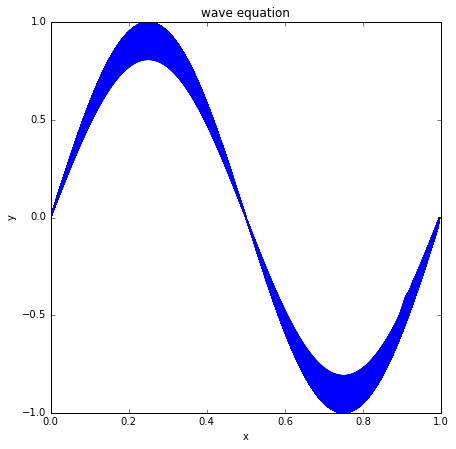

In [112]:
#  1. Plot the values of unew v. x (make sure your arguments to plt.plot() are in the correct order).
#     You may use any line style you like ('b-', 'r--', etc.)
c = 0.01 #wave velocity
t = 10.0 #maximum time
nt = 1000 #munber of time steps (total)
xmin = 0.0 #minimum x-coordinate
xmax = 1.0 #maximum x-coordinate
nx = 250 #number of grid coordinates
dt = t / nt # size of time step
dx = (xmax - xmin) / nx #size of grid coordinates
u = np.zeros(nx+1)
uold = np.zeros(nx+1)
unew = np.zeros(nx+1)
x = np.linspace(xmin,xmax,nx+1)
u = np.sin(2*np.pi*x)
uold = np.copy(u)
s = ((c**2) * (dt**2)) / dx**2
i = 0
j= 1
for i in range(0,nt):
    for j in range(1,nx-1):
        unew[j] = (s * (u[j+1] + u[j-1])) + (2*(1-s)*u[j]) - (uold[j])
    uold = np.copy(u)
    u = np.copy(unew)
    plt.plot(x,unew, 'b-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('wave equation')


#  2. Add labels to the x-axis 'x' and the y-axis 'y', as well as a title 'wave equation'.

# Don't use plt.show(), as it messes up the autograder.
#  Leave this line in for the autograder:
test_axes = plt.gca()

In [113]:
# your code should pass these tests---do NOT edit this cell
from nose.tools import assert_equal, assert_is_not
import matplotlib as mpl

assert_equal(isinstance(test_axes, mpl.axes.Axes), True, msg="\nYour code does not create a plot.")
assert_equal(len(test_axes.lines), 1000, msg="\nYour plot does not have the correct number of lines.  (Did you plt.show() it?  You shouldn't.)")

print('Success!')

Success!


Since every time through the loop, we update the `unew` and `uold` variables with the current and previous values of the system state, we lose the prior information.  This means that we are unable to plot the condition at, say, `t == 50`.

To alleviate this, we can do one of two things:

1.  Store all (or selected) results in a large array by time index.
2.  Plot results as they are generated (but don't keep the values themselves).

We'll do the second this time.

-   Copy your main numerical loop from above and paste it in the cell below.  Then add the following code at the end of the time loop.  (`n` should be whatever your actual time variable is called.)
    
        if n%50 == 0:
            plt.plot(x,unew)
    
    Now when you run the loop, you should generate a plot which has every 50th time step stored as well, giving us a snapshot of the system state at a subset of time steps.
    
    Again, you should *not* run `plt.show()` afterwards since this clears the plot data and makes it impossible for us to check your results.

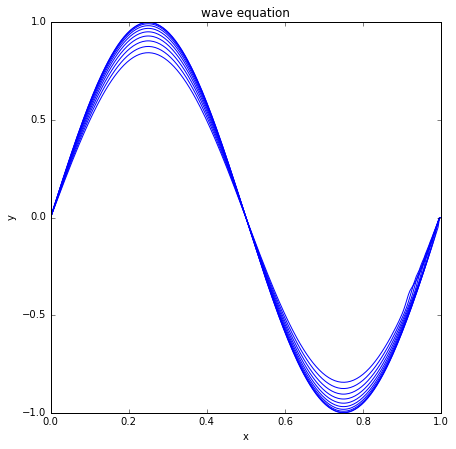

In [114]:
# paste your main numerical loop here to modify it
c = 0.01 #wave velocity
t = 10.0 #maximum time
nt = 1000 #munber of time steps (total)
xmin = 0.0 #minimum x-coordinate
xmax = 1.0 #maximum x-coordinate
nx = 250 #number of grid coordinates
dt = t / nt # size of time step
dx = (xmax - xmin) / nx #size of grid coordinates
u = np.zeros(nx+1)
uold = np.zeros(nx+1)
unew = np.zeros(nx+1)
x = np.linspace(xmin,xmax,nx+1)
u = np.sin(2*np.pi*x)
uold = np.copy(u)
s = ((c**2) * (dt**2)) / dx**2
i = 0
j= 1
for i in range(0,nt):
    for j in range(1,nx-1):
        unew[j] = (s * (u[j+1] + u[j-1])) + (2*(1-s)*u[j]) - (uold[j])
    uold = np.copy(u)
    u = np.copy(unew)
    if  i % 100 ==0:
        plt.plot(x,unew, 'b-')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('wave equation')




# Don't use plt.show(), as it messes up the autograder.
#  Leave this line in for the autograder:
test_axes = plt.gca()

In [116]:
# it should pass this test---do NOT edit this cell
import matplotlib as mpl
from nose.tools import assert_equal, assert_is_not

assert_equal(isinstance(test_axes, mpl.axes.Axes), True, msg="\nYour code does not create a plot named `plot`.")
assert_equal(len(test_axes.lines), 10, msg="\nYour plot does not have the correct number of lines.  (Did you plt.show() it?  You shouldn't.)")
assert_is_not(len(test_axes.xaxis.get_label_text()), 0, msg="\nYour plot does not have labels on the x-axis.")
assert_is_not(len(test_axes.yaxis.get_label_text()), 0, msg="\nYour plot does not have labels on the y-axis.")
assert_is_not(len(test_axes.title.get_text()), 0, msg="\nYour plot does not have a title.")

print('All tests passed successfully.')

All tests passed successfully.


### Plate Harmonics

The beat of a drum or the crash of cymbals relies on more than one-dimensional vibration.  Higher-order harmonics become necessary to describe shapes pulsing or vibrating in higher dimensions.  German physicist Ernst Chladni devised [a clever means of discovering these shapes empirically](https://en.wikipedia.org/wiki/Ernst_Chladni#Chladni_figures):  coat the surface with a thin layer of sand, which concentrates when the plate is struck on the vibrational nodes (or stationary parts of the wave).  Dramatic and beautiful pictures can be obtained.  ([Videos](https://youtu.be/1yaqUI4b974) are also available.)

![](https://i.ytimg.com/vi/wMIvAsZvBiw/hqdefault.jpg)

![](https://static.squarespace.com/static/549dcda5e4b0a47d0ae1db1e/54a06d6ee4b0d158ed95f696/54a06d70e4b0d158ed9602ae/1378862083897/1000w/Chladni_patterns.png)

The mathematical theory of the wave equation underlying this effect in two and three dimensions is now well-understood, and we can use simple assumptions to calculate the modes of vibration for square and circular plates.  Arbitrary shapes require heavier-duty numerics to obtain.

#### Governing Equations

<div class="alert alert-info">
As before, you don't need to follow most of the details of this derivation to solve the lab, but it provides context and motivation for what you're doing.
</div>

In two dimensions, for a square domain, the wave equation is

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0
\hspace{5cm}
\begin{eqnarray}
u(-1,  y, t) = 0 \\
u(+1,  y, t) = 0 \\
u( x, -1, t) = 0 \\
u( y, +1, t) = 0
\end{eqnarray}
\text{.}
$$

Because the solution is a *standing wave* (cyclical in time), we assume that the solution is of the form

$$
u(x,y,t) = \sin\left( 2 \pi f t \right) s\left( x,y \right) \,\text{.}
$$

Putting $u$ into the wave equation yields

$$
- \left( 2 \pi f \right)^2 \sin\left( 2 \pi f \right) s = c^2 \sin\left( 2 \pi f \right) \left( \frac{\partial^2 s}{\partial x^2} + \frac{\partial^2 s}{\partial y^2} \right) \text{,}
$$

which simplifies to

$$
- \left( 2 \pi f \right)^2 s = \left( \frac{\partial^2 s}{\partial x^2} + \frac{\partial^2 s}{\partial y^2} \right) \text{.}
$$

Relying on past mathematical experience, we can posit that $s$ is of the form

$$
s(x,y) = \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} a_{nm} \sin\left( \pi n x \right) \sin\left( \pi m y \right) \text{.}
$$

(This is called a *Fourier series*, a way of representing almost any function as a sum of appropriately-sized sine waves.  In this presentation, I'm waving my hand, but it's a legitimate idea you'll encounter later on in your engineering career.)

Substituting $s$ in, and much algebra later, leads us to a solution of the form

$$
s(x,y) =
  a \sin\left( \pi n x \right) \sin\left( \pi m y \right)
+ b \sin\left( \pi m x \right) \sin\left( \pi n y \right)
\text{.}
$$

Rian Hunter provides [a full step-by-step derivation](https://thelig.ht/chladni/) of the solution; we have followed his method.

Now, *we don't actually have to solve the wave equation to obtain the Chaldni patterns.*  We already know that the lines of sand concentrate at the standing nodes, where the amplitude is zero always.  Therefore we can simply set the form of the equation equal to zero and solve for the lines where this condition holds:

$$
  a \sin\left( \pi n x \right) \sin\left( \pi m y \right)
+ b \sin\left( \pi m x \right) \sin\left( \pi n y \right)
= 0
$$

This will be automatically done by making a *contour plot* of the answer, since there will be a contour at height $u = 0$.

There are four parameters we can set in this equation—$a$, $b$, $m$, $n$—before we can solve for $x$ and $y$.  $a = b = +1$ is a reasonable starting point, but feel free to play around with the values as well.

-   Compose a function `chladni` which accepts as parameters `a`, `b`, `m`, `n`.  `chladni` should return a plot of the solution.  (We return it from the function so we can test it for correctness below.)  Use the following code outline to scaffold your code.

In [120]:
def chladni(a,b,m,n):   # make a and b have defaults of 1
    npts = 101  # set the number of grid points to 101
    
    # Set up coordinate grids in x and y from -1 to +1 with npts intervals in each.  Use NumPy's linspace.
    x = np.linspace(-1,1,npts)
    y = np.linspace(-1,1,npts)
    
    # Set up a solution grid u of size npts x npts.  Use NumPy's zeros or empty.
    u = np.zeros((npts,npts))
    
    # Solve the equation for each point of the grid in x and y.
    # u = a sin(pi*n*x) sin(pi*m*y) + b sin(pi*m*x) sin(pi*n*y)
    # You'll need to import NumPy to get sin and pi.
    for ix in range(npts):
        for iy in range(npts):
            u[ix,iy] = (a * (np.sin(np.pi*n*ix) *(np.sin(np.pi*m*iy)))) + (b * (np.sin(np.pi*m*ix) *(np.sin(np.pi*n*iy))))
    
    # This is a contour plot with one curve and a 5-pixel-thick line.
    plot = plt.contour(x, y, u, 1, linewidths=5)
    
    # Plots are confusing.  But for the kind of plot we want (a contour plot),
    # we have to set the x and y labels like this:
    plot.ax.set_xlabel( 'x' )
    # Set a y label as well:
    plot.ax.set_xlabel( 'y' )
    # Title the plot 'Chladni plot':
    plot.ax.set_title( 'Chladni plot' )
    
    return plot

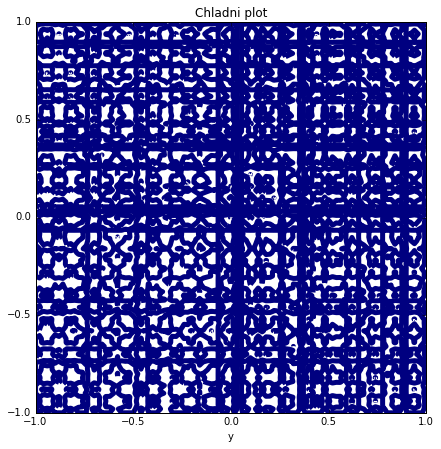

In [121]:
# feel free to test your code here---try lots of values for the parameters!
chladni( 1, 1, -7, 4 )

All tests passed successfully.


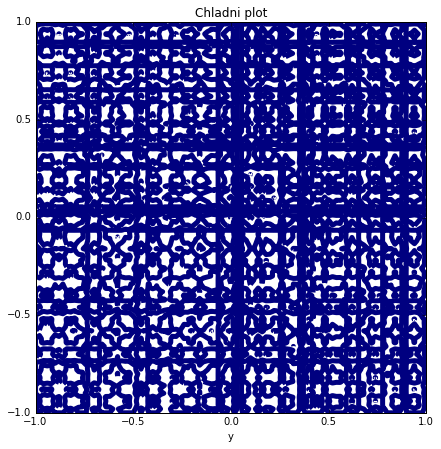

In [122]:
# it should pass this test---do NOT edit this cell
import matplotlib as mpl
from nose.tools import assert_equal, assert_is_not

test_axes = chladni( 1,1,-7,4 )

assert_equal(isinstance(test_axes, mpl.contour.QuadContourSet), True, msg="\nYour function does not return a contour plot.")

print('All tests passed successfully.')

AssertionError: unexpectedly identical: 0 : 
Your plot does not have labels on the y-axis.

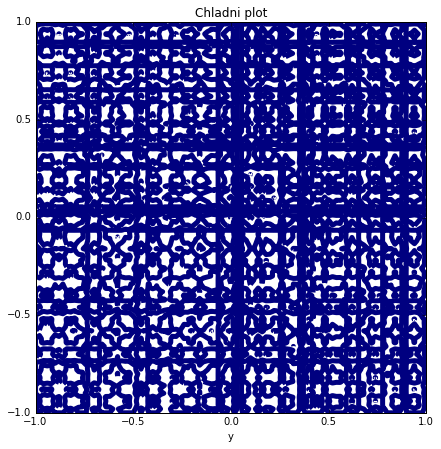

In [124]:
# it should pass this test---do NOT edit this cell
import matplotlib as mpl
from nose.tools import assert_equal, assert_is_not

test_axes = chladni( 1,1,-7,4 )

assert_is_not(len(test_axes.ax.get_xlabel()), 0, msg="\nYour plot does not have labels on the x-axis.")
assert_is_not(len(test_axes.ax.get_ylabel()), 0, msg="\nYour plot does not have labels on the y-axis.")

print('All tests passed successfully.')

## Reference

-   [Chladni, Ernst Florens Friedrich.  (1830)  *Die Akustik*.](https://books.google.ca/books?id=VecsAAAAYAAJ&dq=chladni+die+akustik&pg=RA1-PA93&hl=en#v=onepage&q&f=true)

# Before you submit...

Before you submit this exercise, make sure that everything runs as expected.  You can either use the *Validate* button on the *Assignments* tab or type `nbgrader validate labX` at the command line.  **You should also *save* before submitting.**

Make sure that you have filled in any code block which says "YOUR CODE HERE" or "YOUR ANSWER HERE".

List any resources used (beyond the TA or the help files):

Double-click here to add collaborators or partners:  ☐Jake Graham jpgraha2

This laboratory exercise was written by Neal Davis for Computer Science 101 at the University of Illinois.

©2015–16 University of Illinois

![](./cs101-footer.png)